In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from torchvision import datasets, transforms

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, confusion_matrix

In [3]:
train = datasets.MNIST('../data', train=True, transform=transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST('../data', train=False, transform=transforms.Compose([transforms.ToTensor()]))

In [4]:
def plot(X):
    img = (np.array(X.detach().cpu(), dtype='float')).reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.show()

In [5]:
X = train.data.float() / 255
X = X.reshape(X.shape[0], -1)
y = train.targets

In [6]:
input_size = X.shape[-1]
output_size = int(max(y)) + 1

In [7]:
ratios = [0.8, 0.2]
train_cnt = int(X.shape[0] * ratios[0])
valid_cnt = X.shape[0] - train_cnt
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]
cnts, test_cnt

([48000, 12000], 10000)

In [8]:
indices = torch.randperm(X.shape[0])
X = torch.index_select(X, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)
X = list(X.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

X += [(test.data.float() / 255).reshape(test_cnt, -1)]
y += [test.targets]

for X_i, y_i in zip(X, y):
    print(X_i.shape, y_i.shape)

torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


In [10]:
class Block(nn.Module):
    def __init__(self, input_size, output_size, use_batch_norm=True, dropout_p=0.4):
        self.input_size = input_size
        self.output_size = output_size
        self.use_batch_norm = use_batch_norm
        self.dropout_p = dropout_p

        super().__init__()

        def get_regularizer(use_batch_norm, size):
            return nn.BatchNorm1d(size) if use_batch_norm else nn.Dropout(dropout_p)
        
        self.block = nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.LeakyReLU(),
            get_regularizer(use_batch_norm, output_size)
        )
    
    def forward(self, X):
        y = self.block(X)
        return y

In [11]:
class MyModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes=[500, 400, 300, 200, 100], use_batch_norm=True, dropout_p=0.4):
        super().__init__()

        last_hidden_size = input_size
        blocks = []
        for hidden_size in hidden_sizes:
            blocks += [Block(last_hidden_size, hidden_size, use_batch_norm, dropout_p)]
            last_hidden_size = hidden_size
        
        self.layers = nn.Sequential(
            *blocks,
            nn.Linear(last_hidden_size, output_size),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, X):
        y = self.layers(X)
        return y

In [12]:
model = MyModel(input_size, output_size, use_batch_norm=True)
optimizer = optim.Adam(model.parameters())
crit = nn.NLLLoss()

In [13]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [14]:
n_epochs = 1000
batch_size = 256
print_interval = 10

In [15]:
lowest_loss = np.inf
best_model = None
lowest_epoch = np.inf
early_stop = 50

In [16]:
train_history, valid_history = [], []

for i in range(n_epochs):
    model.train()
    indices = torch.randperm(X[0].shape[0]).to(device)
    X_ = torch.index_select(X[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    X_ = X_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    train_loss, valid_loss = 0, 0
    y_hat = []

    for X_i, y_i in zip(X_, y_):
        y_hat_i = model(X_i)
        loss = crit(y_hat_i, y_i.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += float(loss)
    
    train_loss = train_loss / len(X_)

    model.eval()
    with torch.no_grad():
        X_ = X[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0

        for X_i, y_i in zip(X_, y_):
            y_hat_i = model(X_i)
            loss = crit(y_hat_i, y_i.squeeze())

            valid_loss += float(loss)

            y_hat += [y_hat_i]

    valid_loss = valid_loss / len(X_)

    train_history += [train_loss]
    valid_history += [valid_loss]

    if valid_loss < lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and early_stop + lowest_epoch < i + 1:
            print(f'There is no improvement during last {early_stop} epochs.')
            break

    if (i + 1) % print_interval == 0:
        print(f'Epoch {i + 1}: train loss={train_loss:.6f}, valid loss={valid_loss:.6f}, lowest loss={lowest_loss:.6f}')

print(f'The best validation loss from epoch {lowest_epoch + 1}: {lowest_loss:.6f}')

model.load_state_dict(best_model)

Epoch 10: train loss=0.020626, valid loss=0.095829, lowest loss=0.080041
Epoch 20: train loss=0.007780, valid loss=0.088838, lowest loss=0.080041
Epoch 30: train loss=0.009562, valid loss=0.083097, lowest loss=0.076382
Epoch 40: train loss=0.004058, valid loss=0.087807, lowest loss=0.076382
Epoch 50: train loss=0.003548, valid loss=0.088694, lowest loss=0.076382
Epoch 60: train loss=0.002706, valid loss=0.106088, lowest loss=0.076382
Epoch 70: train loss=0.003154, valid loss=0.095241, lowest loss=0.076382
There is no improvement during last 50 epochs.
The best validation loss from epoch 24: 0.076382


<All keys matched successfully>

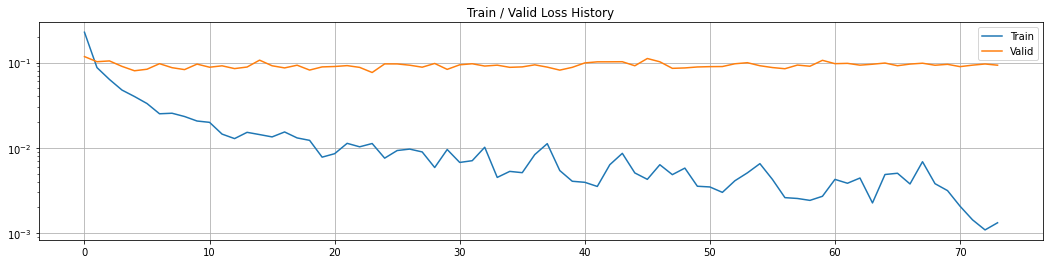

In [17]:
plot_from = 0

fig, ax = plt.subplots(1, 1, figsize=(18, 4))
plt.title('Train / Valid Loss History')
ax.plot(range(plot_from, len(train_history)), train_history[plot_from:],
         range(plot_from, len(valid_history)), valid_history[plot_from:])
plt.grid(True)
plt.yscale('log')
plt.legend(['Train', 'Valid'])
plt.show()

In [18]:
model.eval()
with torch.no_grad():
    X_ = X[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)

    test_loss = 0
    y_hat = []
    
    for X_i, y_i in zip(X_, y_):
        y_hat_i = model(X_i)
        loss = crit(y_hat_i, y_i.squeeze())

        test_loss += float(loss)
        y_hat += [y_hat_i]

test_loss = test_loss / len(X_)
y_hat = torch.concat(y_hat, dim=0)

sorted_history = sorted(zip(train_history, valid_history), key=lambda x: x[1])

print(f'Train loss: {sorted_history[0][0]:.4f}')
print(f'Valid loss: {sorted_history[0][1]:.4f}')
print(f'Test loss: {test_loss:.4f}')

Train loss: 0.0112
Valid loss: 0.0764
Test loss: 0.0718


In [19]:
correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = y[-1].shape[0]
print(f'Test Accuracy: {correct_cnt / total_cnt:.2%}')

Test Accuracy: 98.11%


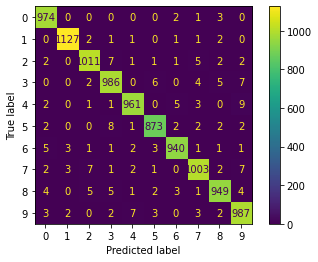

In [20]:
ConfusionMatrixDisplay.from_predictions(y[-1].squeeze(), torch.argmax(y_hat, dim=-1))